In [1]:
!apt-get update --quiet > /dev/null 2>&1
!apt-get install -y chromium-chromedriver --quiet > /dev/null 2>&1
!cp /usr/lib/chromium-browser/chromedriver /usr/bin --quiet > /dev/null 2>&1
!pip install selenium --quiet > /dev/null 2>&1
!pip install beautifulsoup4 --quiet > /dev/null 2>&1
!pip install requests --quiet > /dev/null 2>&1
!pip install wbdata --quiet > /dev/null 2>&1

In [2]:
import time
import random
import datetime
from datetime import datetime as dt
from urllib.parse import urljoin

import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams["font.family"] = "DejaVu Sans"

from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import wbdata

from IPython.display import display, HTML, Audio

In [3]:
# Selenium設定
options = Options()
options.add_argument('--headless')
options.add_argument('--disable-gpu')
options.add_argument('--no-sandbox')
driver = webdriver.Chrome(options=options)

📰 最新記事 (トップ5)


,date,title,url
11,2025-05-29,「数日で終わるはずが…」前代未聞の大使館占拠なぜ起きた？,https://www3.nhk.or.jp/news/html/20250529/k100...
17,2025-05-30,4【お米マイスター直伝】古米 どう食べる？パサつき においは,https://www3.nhk.or.jp/news/html/20250530/k100...
16,2025-05-30,2石破首相“偏見や差別ない共生社会実現へ政府一丸で取り組む”,https://www3.nhk.or.jp/news/html/20250530/k100...
13,2025-05-30,のり製品も 6月に値上げの食品 1900品目超に 節約のポイントは,https://www3.nhk.or.jp/news/html/20250530/k100...
20,2025-05-30,5小室眞子さん出産 宮内庁が発表,https://www3.nhk.or.jp/news/html/20250530/k100...


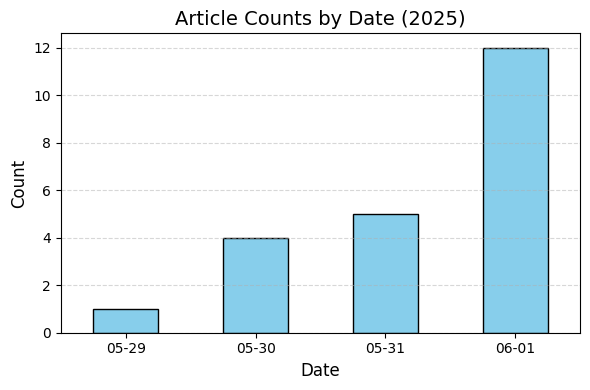

In [4]:
# 1. ニュースサイトから日付＋タイトル収集

# NHKトップページアクセス
base_url = 'https://www3.nhk.or.jp/news/'
driver.get(base_url)
time.sleep(5)

# 記事リンクの収集 (最大30件)
soup = BeautifulSoup(driver.page_source, 'html.parser')
seen = set()
target_articles = []

for a_tag in soup.find_all('a', href=True):
    title = a_tag.get_text(strip=True)
    href = a_tag['href']
    if title and href.startswith('/news/html/') and 'html' in href:
        full_url = 'https://www3.nhk.or.jp' + href
        if full_url not in seen:
            seen.add(full_url)
            target_articles.append({"title": title, "url": full_url})
    if len(target_articles) >= 30:
        break

# 各記事ページで日付を取得
results = []

for article in target_articles:
    try:
        driver.get(article["url"])
        time.sleep(0.5)
        detail_soup = BeautifulSoup(driver.page_source, "html.parser")

        time_tag = detail_soup.find("time")
        if time_tag and time_tag.has_attr("datetime"):
            pub_date = time_tag["datetime"].split("T")[0]
        else:
            pub_date = datetime.today().strftime("%Y-%m-%d")

        results.append({
            "date": pub_date,
            "title": article["title"],
            "url": article["url"]
        })

    except Exception as e:
        print("スキップ：", article["url"], str(e))

# ドライバー終了
driver.quit()

# DataFrame化
df = pd.DataFrame(results)
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

# 表：上位5件のニュース記事
print("📰 最新記事 (トップ5)")
display(df[["date", "title", "url"]].head())

# 棒グラフで日別記事数を可視化
df["date_only"] = df["date"].dt.date
counts = df["date_only"].value_counts().sort_index()
labels = [d.strftime("%m-%d") for d in counts.index]

counts.plot(kind="bar", figsize=(6, 4), color="skyblue", edgecolor="black")
plt.title("Article Counts by Date (2025)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [5]:
# 2. ランダム画像の収集と可視化 (擬似スクレイピング)

# ランダム画像URLを収集
image_urls = [
    f"https://picsum.photos/seed/{random.randint(1, 10000)}/200/150"
    for _ in range(12)  # 12枚 (4列×3行)
]

# 表形式(4列)のHTMLテーブルを作成
html = """
<h3>📸 画像をNotebook上に表示：</h3>
<table style="border-collapse: collapse;">
"""

for i in range(0, len(image_urls), 4):
    html += "<tr>"
    for j in range(4):
        if i + j < len(image_urls):
            img_url = image_urls[i + j]
            html += f"""
            <td style="padding: 10px; vertical-align: top;">
                <img src="{img_url}" width="180"><br>
                画像 {i + j + 1}<br>
                <a href="{img_url}" target="_blank">{img_url}</a>
            </td>
            """
    html += "</tr>"

html += "</table>"

display(HTML(html))

画像 1 https://picsum.photos/seed/2832/200/150,画像 2 https://picsum.photos/seed/9606/200/150,画像 3 https://picsum.photos/seed/4566/200/150,画像 4 https://picsum.photos/seed/8272/200/150
画像 5 https://picsum.photos/seed/3772/200/150,画像 6 https://picsum.photos/seed/9225/200/150,画像 7 https://picsum.photos/seed/7401/200/150,画像 8 https://picsum.photos/seed/4508/200/150
画像 9 https://picsum.photos/seed/8956/200/150,画像 10 https://picsum.photos/seed/4747/200/150,画像 11 https://picsum.photos/seed/9197/200/150,画像 12 https://picsum.photos/seed/3165/200/150


In [6]:
# 3. 音楽サイトから音声ファイルを取得して再生

# MP3サンプルサイトにアクセス
base_url = "https://samplelib.com/sample-mp3.html"
headers = {"User-Agent": "Mozilla/5.0"}
res = requests.get(base_url, headers=headers)
soup = BeautifulSoup(res.text, "html.parser")

# MP3リンクを抽出 (絶対URLに変換)
mp3_links = []
for a in soup.find_all("a", href=True):
    if a['href'].endswith(".mp3"):
        full_url = urljoin(base_url, a['href'])
        mp3_links.append(full_url)

# 音声をNotebook上で再生 (最大3つ)
for i, link in enumerate(mp3_links[:3], 1):
    print(f"🎵 トラック {i}: {link}")
    display(Audio(url=link, autoplay=False))

🎵 トラック 1: https://download.samplelib.com/mp3/sample-3s.mp3


🎵 トラック 2: https://download.samplelib.com/mp3/sample-6s.mp3


🎵 トラック 3: https://download.samplelib.com/mp3/sample-9s.mp3


In [7]:
# Seleniumの再セットアップ
options = Options()
options.add_argument('--headless')
options.add_argument('--disable-gpu')
options.add_argument('--no-sandbox')
driver = webdriver.Chrome(options=options)

In [8]:
# 4. TEDトークを一覧表示 (タイトル＋リンク＋埋め込み動画)

# TED Talksトップページへアクセス
base_url = "https://www.ted.com/talks"
driver.get(base_url)
time.sleep(5)  # JavaScript描画のために待機

soup = BeautifulSoup(driver.page_source, "html.parser")

# トーク情報を抽出
talks = []
for a in soup.find_all("a", href=True):
    href = a["href"]
    if href.startswith("/talks/") and not href.startswith("/talks/playlists"):
        title = a.get_text(strip=True)
        if title:
            full_url = urljoin(base_url, href)
            embed_url = href.replace("/talks/", "https://embed.ted.com/talks/")
            talks.append({
                "タイトル": title,
                "リンク": full_url,
                "埋め込みURL": embed_url
            })

# ドライバー終了
driver.quit()

# DataFrameに変換 (重複除去)
df_ted = pd.DataFrame(talks).drop_duplicates(subset="リンク")

# 表形式で表示 (先頭9件)
html = """
<h3>🎥 TEDトーク一覧:</h3>
<table style="border-collapse: collapse; width: 100%;">
"""

rows = df_ted.head(9).reset_index(drop=True)
for i in range(0, len(rows), 3):  # 3列ずつ
    html += "<tr>"
    for j in range(3):
        if i + j < len(rows):
            row = rows.iloc[i + j]
            html += f"""
            <td style="padding: 10px; width: 33%; vertical-align: top;">
                <div style="width: 300px; white-space: nowrap; overflow: hidden; text-overflow: ellipsis;">
                    <b>{row['タイトル']}</b>
                </div>
                <div style="width: 300px; white-space: nowrap; overflow: hidden; text-overflow: ellipsis;">
                    <a href="{row['リンク']}" target="_blank">{row['リンク']}</a>
                </div>
                <br>
                <iframe width="300" height="170" src="{row['埋め込みURL']}" frameborder="0" allowfullscreen></iframe>
            </td>
            """
    html += "</tr>"

html += "</table>"
display(HTML(html))

10:41How to build in space for life on EarthAriel Ekblaw https://www.ted.com/talks/ariel_ekblaw_how_to_build_in_space_for_life_on_earth,"07:18Let your ambition light you up, not burn you outTarveen Forrester https://www.ted.com/talks/tarveen_forrester_let_your_ambition_light_you_up_not_burn_you_out",11:21Why does uncertainty bother us so much?Adam Kucharski https://www.ted.com/talks/adam_kucharski_why_does_uncertainty_bother_us_so_much
10:42The future isn't just coded — it's builtLauren Dunford https://www.ted.com/talks/lauren_dunford_the_future_isn_t_just_coded_it_s_built,10:36Is this the time of monsters — or miracles?Angus Hervey https://www.ted.com/talks/angus_hervey_is_this_the_time_of_monsters_or_miracles,04:49How I turned frustration into creative successJoshua Schachter https://www.ted.com/talks/joshua_schachter_how_i_turned_frustration_into_creative_success
15:50Why love is harder in a second languageMagdalena Hoeller https://www.ted.com/talks/magdalena_hoeller_why_love_is_harder_in_a_second_language_may_2025,11:01This is what the future of media looks likeHamish McKenzie https://www.ted.com/talks/hamish_mckenzie_this_is_what_the_future_of_media_looks_like,14:52The catastrophic risks of AI — and a safer pathYoshua Bengio https://www.ted.com/talks/yoshua_bengio_the_catastrophic_risks_of_ai_and_a_safer_path


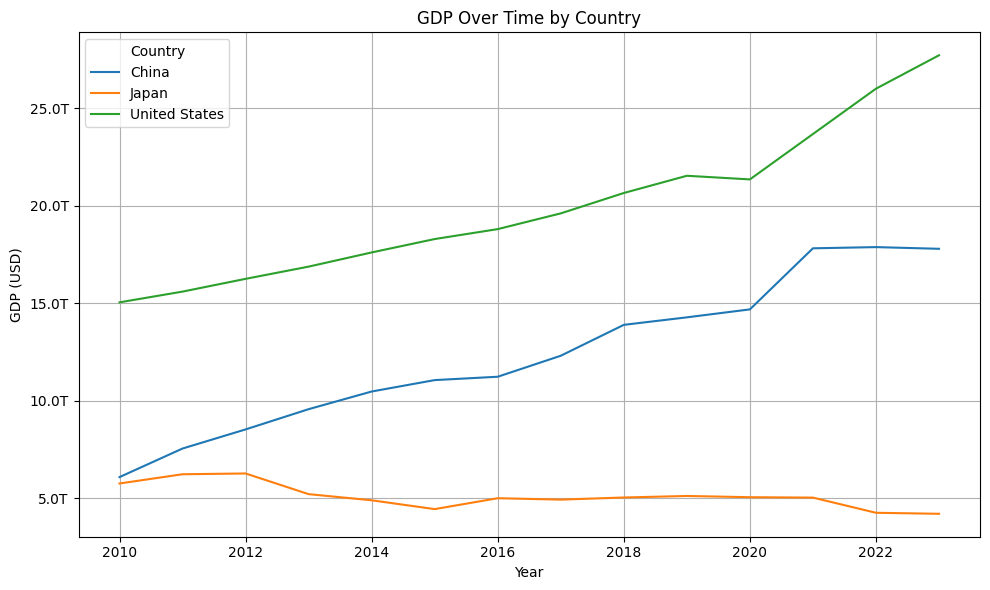

In [9]:
# 5. 世界銀行のGDPデータを収集・可視化

# データ取得の設定
indicator = {"NY.GDP.MKTP.CD": "GDP"}
countries = ["JP", "CN", "US"]
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2023, 1, 1)

# データ取得
df = wbdata.get_dataframe(indicator, country=countries, date=(start_date, end_date))
df = df.reset_index()
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df = df.rename(columns={"country": "Country", "GDP": "GDP(USD)"})

# グラフ描画
plt.figure(figsize=(10, 6))
for country in df["Country"].unique():
    data = df[df["Country"] == country]
    plt.plot(data["year"], data["GDP(USD)"], label=country)

# 軸とラベル
plt.title("GDP Over Time by Country")
plt.xlabel("Year")
plt.ylabel("GDP (USD)")
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x*1e-12:.1f}T'))
plt.legend(title="Country")
plt.grid(True)
plt.tight_layout()
plt.show()